In [1]:
# Import necessary dependencies
import dask.bag as db
import re
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 1. Data Collection

In [2]:
import dask.bag as db
from dask.diagnostics import ProgressBar
import pandas as pd
import json

docs = db.read_text("/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json").map(json.loads)

In [3]:
from multiprocessing import Pool, cpu_count

def process_chunk(chunk):
    """Process a chunk of JSON lines."""
    data = []
    for line in chunk:
        record = json.loads(line)
        trimmed_record = {
            'id': record['id'],
            'title': record['title'],
            'category': record['categories'].split(' '),
            'abstract': record['abstract'],
            'authors': record['authors'],
            'authors_parsed': record['authors_parsed'],
            'update_date': record['update_date'],
        }
        data.append(trimmed_record)
    return data

def read_in_chunks(file_path, chunk_size=1000):
    """Lazy function to read a file in chunks."""
    with open(file_path, 'r') as file:
        chunk = []
        for line in file:
            chunk.append(line)
            if len(chunk) == chunk_size:
                yield chunk
                chunk = []
        if chunk:
            yield chunk


file_path = "/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json"

chunk_size = 1000
pool = Pool(cpu_count())

all_data = []
for chunk in read_in_chunks(file_path, chunk_size):
    processed_chunk = pool.map(process_chunk, [chunk])
    all_data.extend(processed_chunk[0])

pool.close()
pool.join()

docs_df = pd.DataFrame(all_data)
docs_df.head()

,id,title,category,abstract,authors,authors_parsed,update_date
0,0704.0001,Calculation of prompt diphoton production cros...,[hep-ph],A fully differential calculation in perturba...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...","[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",2008-11-26
1,0704.0002,Sparsity-certifying Graph Decompositions,"[math.CO, cs.CG]","We describe a new algorithm, the $(k,\ell)$-...",Ileana Streinu and Louis Theran,"[[Streinu, Ileana, ], [Theran, Louis, ]]",2008-12-13
2,0704.0003,The evolution of the Earth-Moon system based o...,[physics.gen-ph],The evolution of Earth-Moon system is descri...,Hongjun Pan,"[[Pan, Hongjun, ]]",2008-01-13
3,0704.0004,A determinant of Stirling cycle numbers counts...,[math.CO],We show that a determinant of Stirling cycle...,David Callan,"[[Callan, David, ]]",2007-05-23
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,"[math.CA, math.FA]",In this paper we show how to compute the $\L...,Wael Abu-Shammala and Alberto Torchinsky,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]",2013-10-15


In [4]:
import copy
df = copy.deepcopy(docs_df)

# 2. Data Description

In [5]:
docs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2730173 entries, 0 to 2730172
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   title           object
 2   category        object
 3   abstract        object
 4   authors         object
 5   authors_parsed  object
 6   update_date     object
dtypes: object(7)
memory usage: 145.8+ MB


In [6]:
# all columns are objects, not numeric, thus df.describe() cannot help
# docs_df.describe()

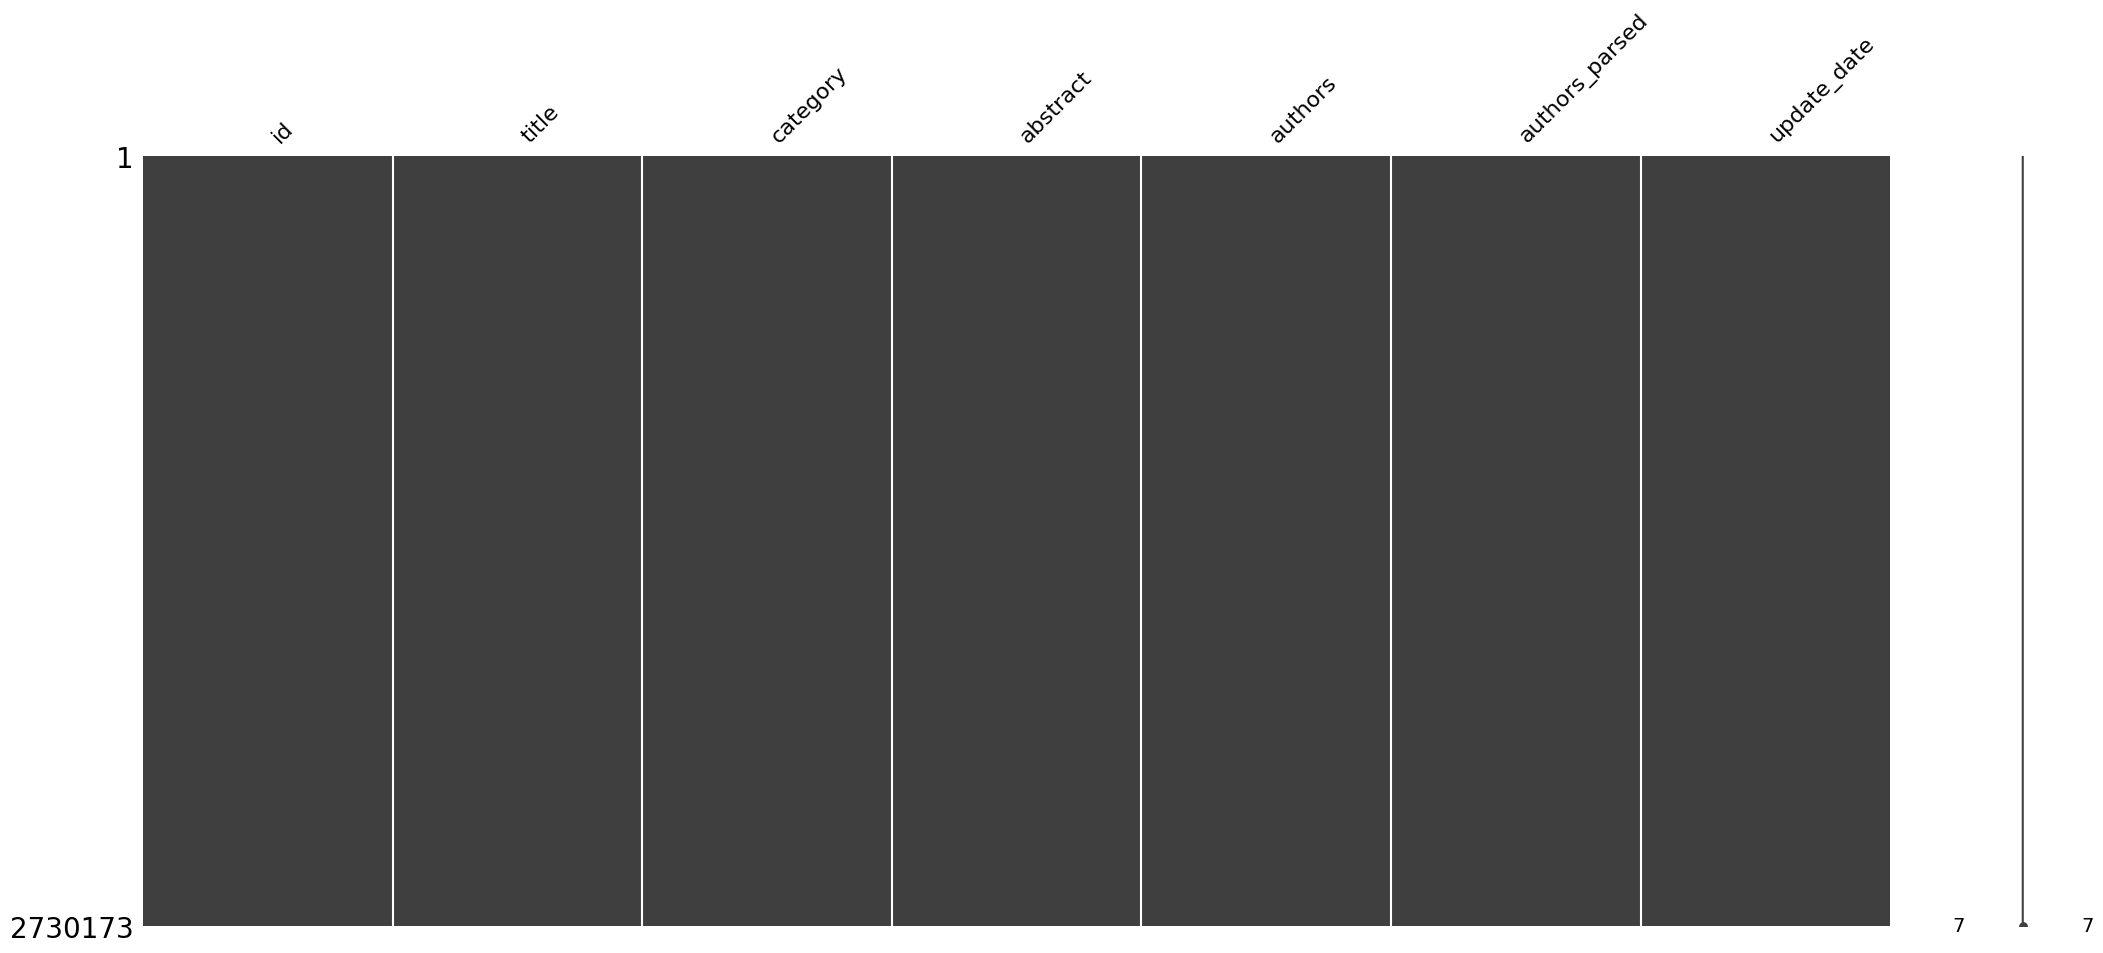

In [7]:
import missingno as msno
msno.matrix(docs_df)
plt.show()

In [8]:
docs_df.isna().sum()

id                0
title             0
category          0
abstract          0
authors           0
authors_parsed    0
update_date       0
dtype: int64

Lets form new columns with more information:

In [6]:
# form dates
docs_df["update_date"] = pd.to_datetime(docs_df.loc[:, "update_date"])
docs_df.loc[:, "update_date"].head()

0   2008-11-26
1   2008-12-13
2   2008-01-13
3   2007-05-23
4   2013-10-15
Name: update_date, dtype: datetime64[ns]

In [7]:
# check the range of dates
dates = docs_df.loc[:, "update_date"].sort_values(ascending=False)
print(f"The date range: {dates.min()} - {dates.max()}")

The date range: 2007-05-23 00:00:00 - 2025-05-09 00:00:00


In [8]:
# apply regex to extract relevant information from "authors" column:
# assumption: each pair of author names is separated either by "," or "and".
pattern = r",\s*|\s+and\s+"
docs_df["authors"] = docs_df.loc[:, "authors"].apply(lambda x: re.split(pattern, x))
# now column has lists with strings - authors names

In [9]:
# also lets compute how many authors each paper has:
docs_df["num_authors"] = docs_df["authors_parsed"].apply(len)

In [10]:
docs_df.head()

,id,title,category,abstract,authors,authors_parsed,update_date,num_authors
0,0704.0001,Calculation of prompt diphoton production cros...,[hep-ph],A fully differential calculation in perturba...,"[C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C....","[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,...",2008-11-26,4
1,0704.0002,Sparsity-certifying Graph Decompositions,"[math.CO, cs.CG]","We describe a new algorithm, the $(k,\ell)$-...","[Ileana Streinu, Louis Theran]","[[Streinu, Ileana, ], [Theran, Louis, ]]",2008-12-13,2
2,0704.0003,The evolution of the Earth-Moon system based o...,[physics.gen-ph],The evolution of Earth-Moon system is descri...,[Hongjun Pan],"[[Pan, Hongjun, ]]",2008-01-13,1
3,0704.0004,A determinant of Stirling cycle numbers counts...,[math.CO],We show that a determinant of Stirling cycle...,[David Callan],"[[Callan, David, ]]",2007-05-23,1
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,"[math.CA, math.FA]",In this paper we show how to compute the $\L...,"[Wael Abu-Shammala, Alberto Torchinsky]","[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]",2013-10-15,2


As we see, there are a few numeric columns, so correlation matrices aren't relevant here

# 3. Data Exploration

### Categories

In [14]:
docs_df.loc[:, "category"].head()

0              [hep-ph]
1      [math.CO, cs.CG]
2      [physics.gen-ph]
3             [math.CO]
4    [math.CA, math.FA]
Name: category, dtype: object

In [15]:
# Calculate the amount of each unique category
unique_cats_count = docs_df.loc[:, "category"].explode().value_counts()
unique_cats_count = unique_cats_count.reset_index()
unique_cats_count.head()

,category,count
0,cs.LG,215824
1,hep-ph,187339
2,hep-th,173525
3,quant-ph,161515
4,cs.CV,154368


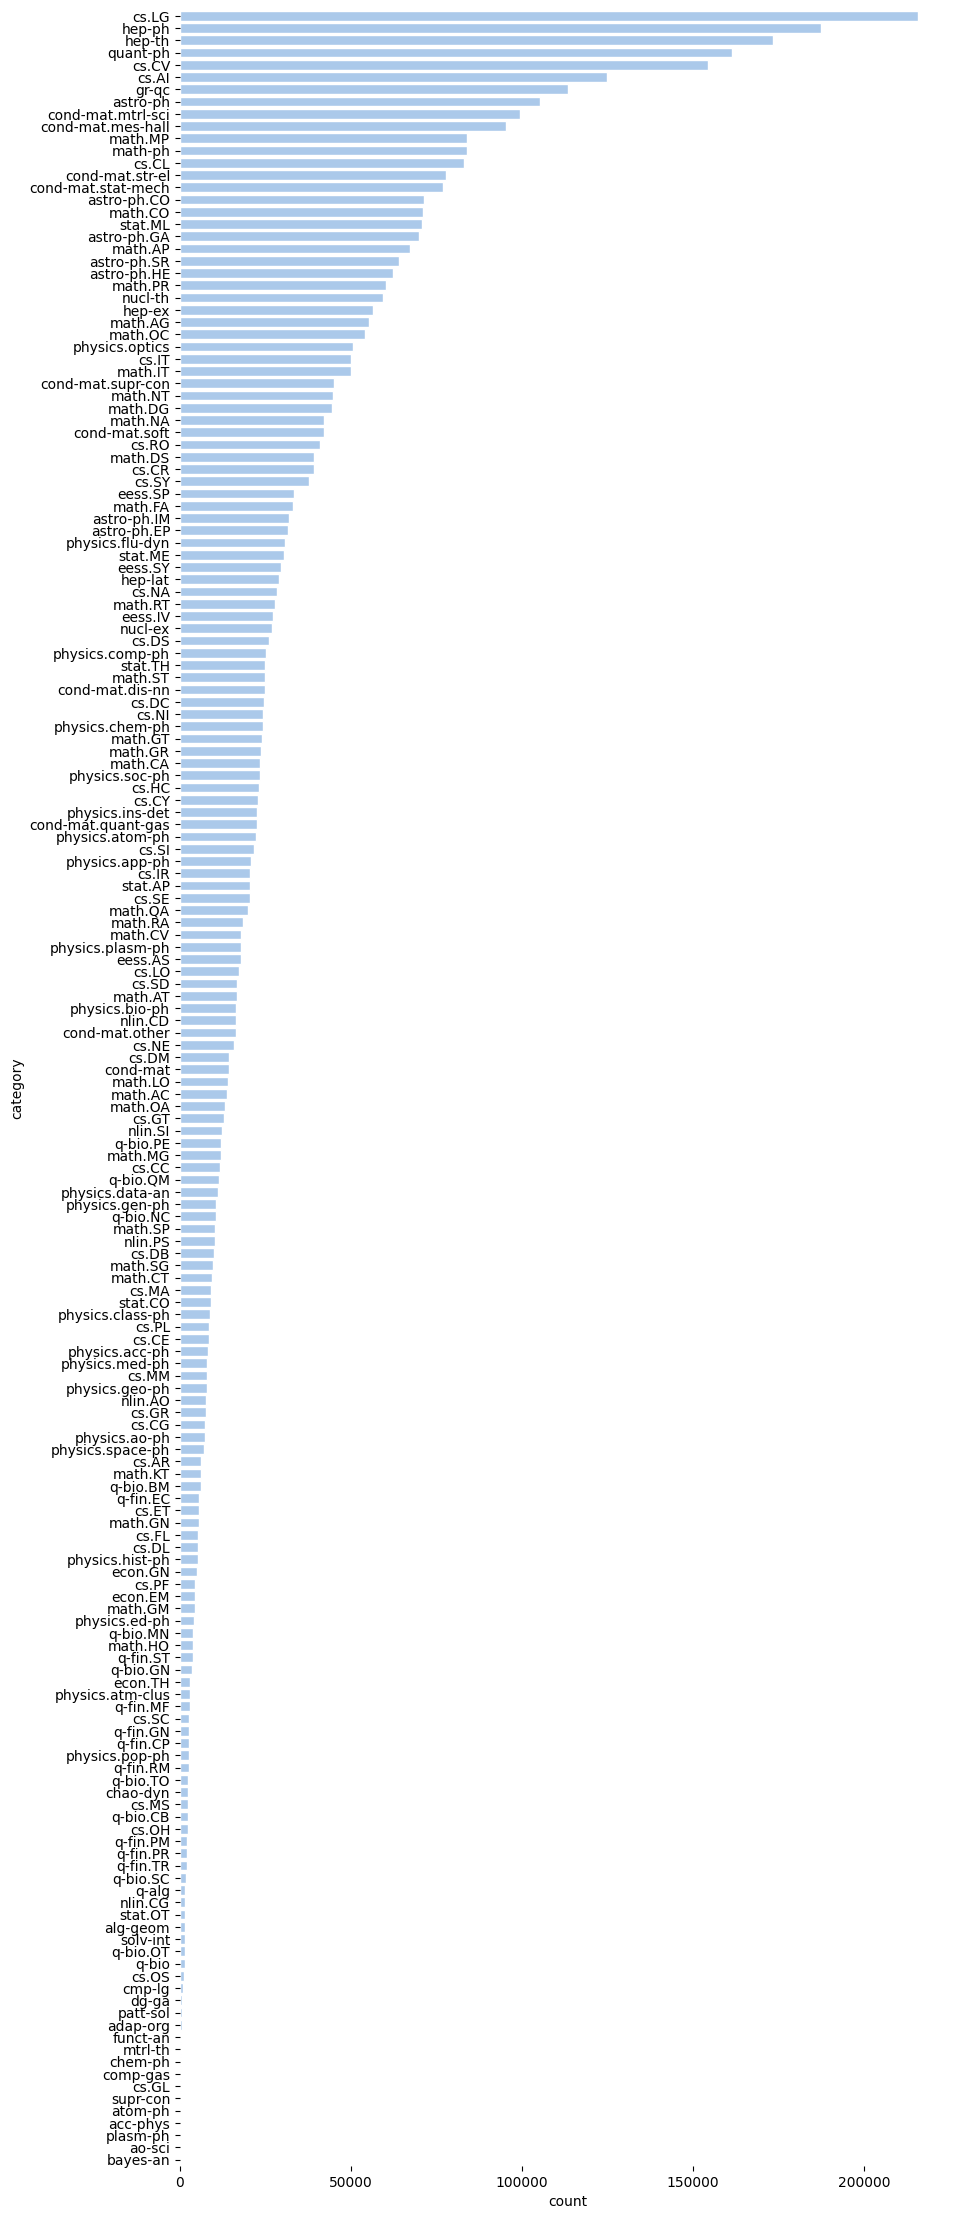

In [16]:
# Plot the distribution for all the categories
fig, ax = plt.subplots(figsize=(10, 28))

sns.set_theme(style="whitegrid", palette="pastel")
sns.barplot(unique_cats_count, x="count", y="category", color="b")
sns.despine(left=True, bottom=True)

As you can see, we have a pretty large amount of categories. We have 2 possible choices here:
- Combine less popular categories into one (e.g. "unknown") via threshold;
- Bin this variable with the respect to the target variable (e.g. [OptBinning](https://gnpalencia.org/optbinning/)).

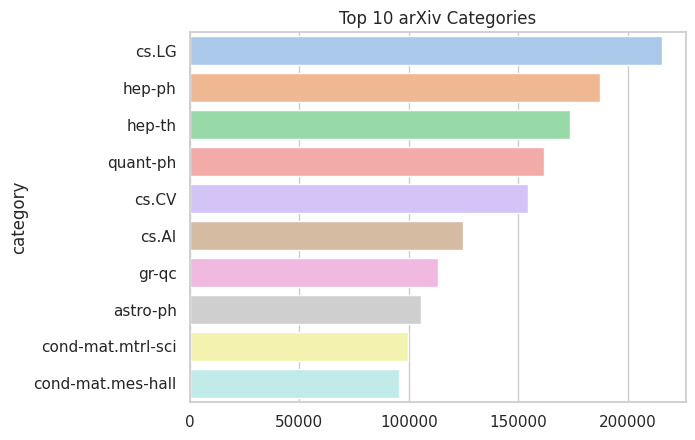

In [17]:
# lets see top 10 categories more precise:
unique_cats_count = df['category'].explode().value_counts().head(10)
sns.barplot(x=unique_cats_count.values, y=unique_cats_count.index)
plt.title("Top 10 arXiv Categories")
plt.show()

Some papers have more than 1 category. Lets see the distribution:

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


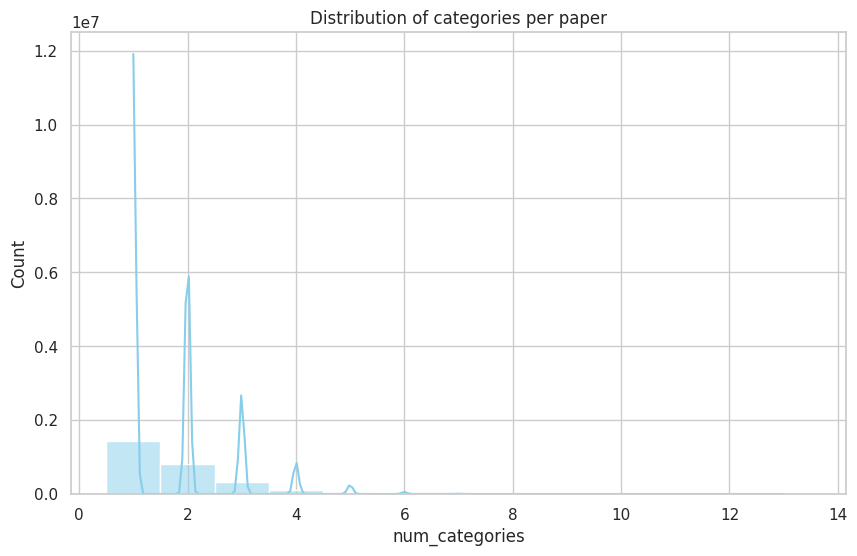

In [18]:
docs_df['num_categories'] = docs_df['category'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(docs_df['num_categories'], bins=14,
             discrete=True, kde=True, color='skyblue')
plt.title('Distribution of categories per paper')
plt.show()

Since we need to find underrepresented areas, we need to understand, what are the most popular categories and how their popularity was chnaging over time:

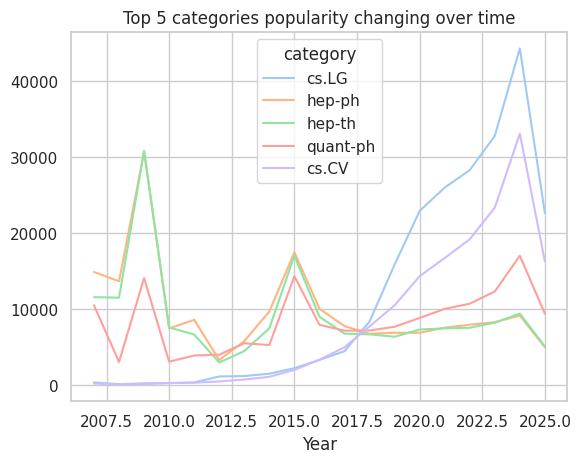

In [19]:
docs_df['year'] = docs_df['update_date'].dt.year
exploded_df = docs_df.explode('category')

category_year_counts = exploded_df.groupby(['year', 'category']).size().unstack(fill_value=0)
top_5 = category_year_counts.sum().sort_values(ascending=False).head(5)
top_5 = list(top_5.index)

category_year_counts[top_5].plot()
plt.title('Top 5 categories popularity changing over time')
plt.xlabel('Year')
plt.show()

Here we see that several years have a lot of publications. For example 2015 is a peack for quantum physics and high energy physics (theory and practise).

Also, most of papers have more than 1 category assigned ot it. We need to know what areas are "friends" with other areas (find their co-occurences):

In [37]:
from itertools import combinations
from collections import defaultdict

co_occurrence = defaultdict(int)
for cats in docs_df['category']:
    if len(cats) > 1:
        for pair in combinations(cats, 2):
            co_occurrence[pair] += 1

top_pairs = sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)[:20]
for (cat1, cat2), count in top_pairs:
    print(f"{cat1} & {cat2}: {count}")

math-ph & math.MP: 83934
cs.IT & math.IT: 50003
cs.LG & stat.ML: 44276
cs.LG & cs.AI: 28757
gr-qc & hep-th: 28695
cs.CV & cs.LG: 28664
cs.AI & cs.LG: 27067
math.ST & stat.TH: 24952
hep-th & gr-qc: 21391
hep-ph & hep-ex: 21163
hep-ph & hep-th: 20034
math.NA & cs.NA: 19212
hep-ph & nucl-th: 19070
hep-th & math.MP: 19040
cs.CL & cs.AI: 18294
cs.CL & cs.LG: 17213
cs.CV & cs.AI: 16995
eess.SY & cs.SY: 16847
stat.ML & cs.LG: 15262
hep-th & math-ph: 14183


So, IT categories are common with other IT categories and math. Math is common to statistics. Astrophysics is common to Quantum Cosmology. 

Lets check the connectivity graph:

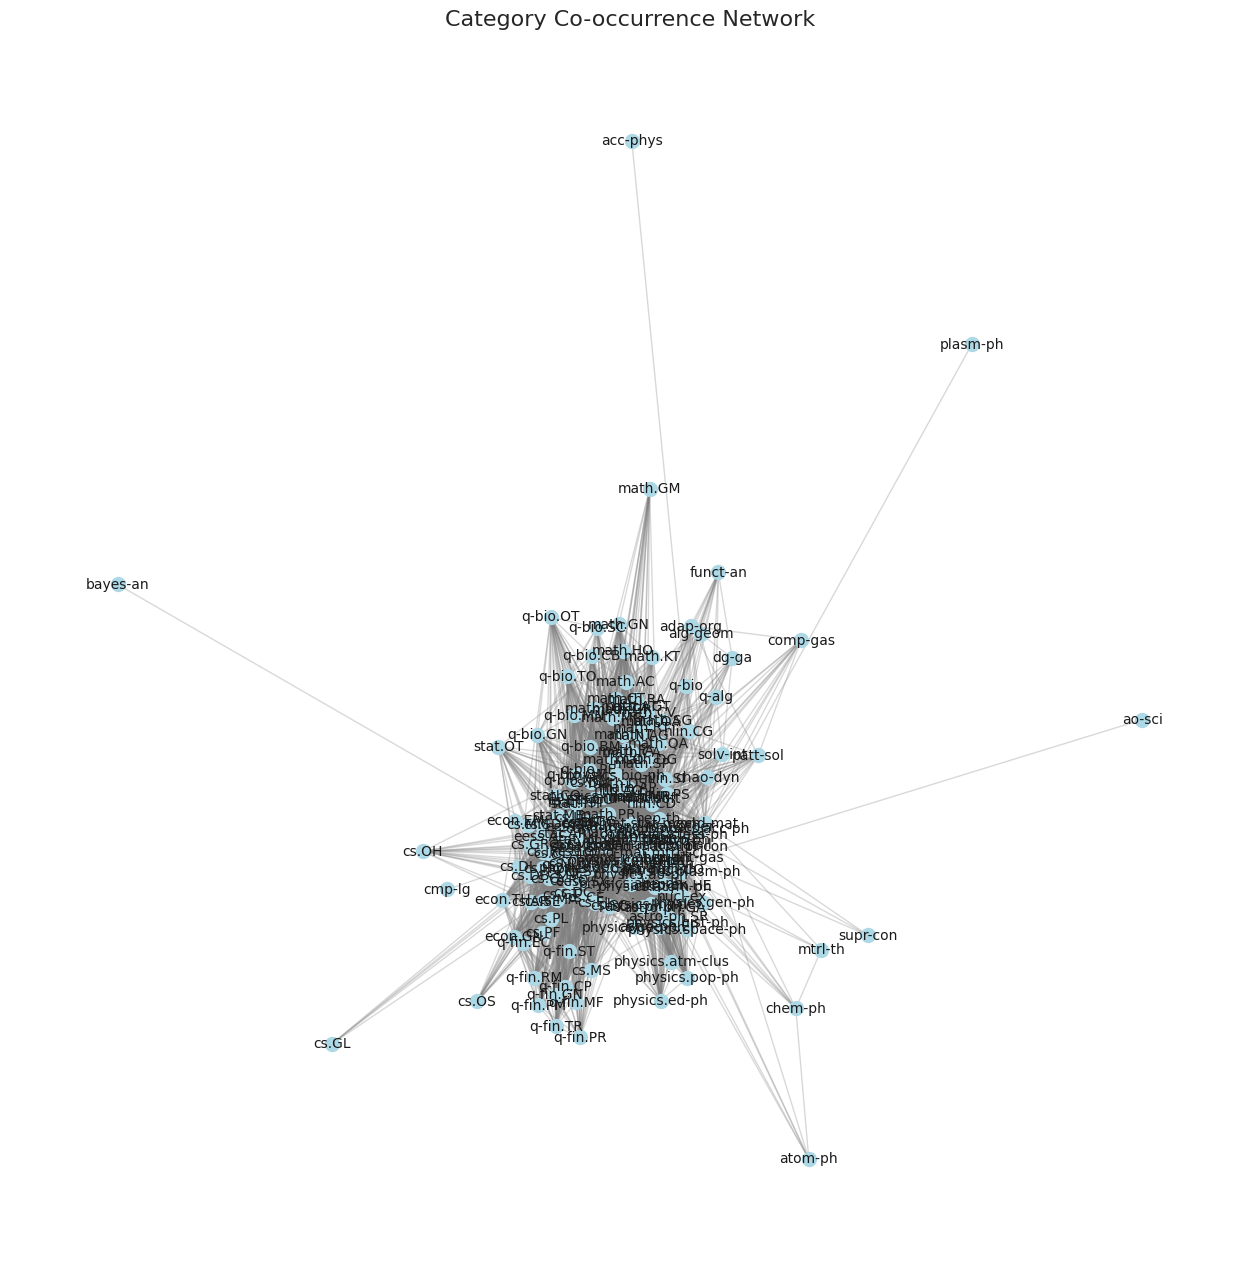

In [39]:
# create the networkx graph

import networkx as nx

# now lets compute the paired(!) co-occurence
# compute the occurence of each pair in papers' categories:
categories = df['category'].explode().unique()


# create the graph: insert edges, but remove edges where categpries appear together less than 10 times
# to avoid too complex and not interpretable plot
G = nx.Graph()
for cat1 in categories:
    for cat2 in categories:
        if co_occurrence[(cat1, cat2)] > 10 and cat1 != cat2:
            G.add_edge(cat1, cat2, weight=co_occurrence[(cat1, cat2)])

# and plot
plt.figure(figsize=(16, 16))

pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx_nodes(G, pos,node_size=100, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title("Co-occurrence network of arXiv categories")
plt.axis('off')
plt.show()

Also we have "parallel_categories" option in the plotly. Lets use the variable from the previous cell "co_occurrence" with counts and see results:

In [41]:
pairs = sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)

categories_paired_count = pd.DataFrame([(pair[0][0], pair[0][1], pair[1]) for pair in pairs])

categories_paired_count.columns = ['cat1', 'cat2', 'value']
fig = px.parallel_categories(
    categories_paired_count.nlargest(40, 'value'),
    dimensions=['cat1', 'cat2'],
    color='value',
    color_continuous_scale='Viridis',
    title='Intercategory collaboration'
)
fig.update_layout(height=800)
fig.show()

In [ ]:
del unique_cats_count
del exploded_df
del category_year_counts
del top_5
del co_occurrence
del top_pairs
del G
del categories
del categories_paired
del pair_counts

### Authors

In [41]:
docs_df.loc[0, "authors"]

["C. Bal\\'azs", 'E. L. Berger', 'P. M. Nadolsky', 'C.-P. Yuan']

In [42]:
unique_authors_amount = docs_df.loc[:, "authors"] \
    .apply(lambda x: [i for i in x if len(i.split()) > 1]).explode().value_counts()
print(unique_authors_amount.shape[0])
unique_authors_amount.head(20)

2715272


authors
et al                  3074
Y. Zhang               2697
Yang Liu               2051
Y. Wang                1962
J. Wang                1923
Wei Wang               1754
Z. Wang                1750
Y. Li                  1728
Lei Zhang              1543
X. Liu                 1515
Takashi Taniguchi      1501
Y. Liu                 1485
Y. Gao                 1468
Kenji Watanabe         1446
Z. Xu                  1364
Wei Zhang              1363
CMS Collaboration      1362
C. Li                  1347
L. Zhang               1321
ATLAS Collaboration    1303
Name: count, dtype: int64

As you can see, we have quite a lot of authors. Even "et al." is here. What a legendary man. \
It is quite hard to transform this variable into a categorical one. Moreover, it is almost pointless to search h-index for each author due to lack of full name in most cases.

2832


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='num_authors', ylabel='Count'>

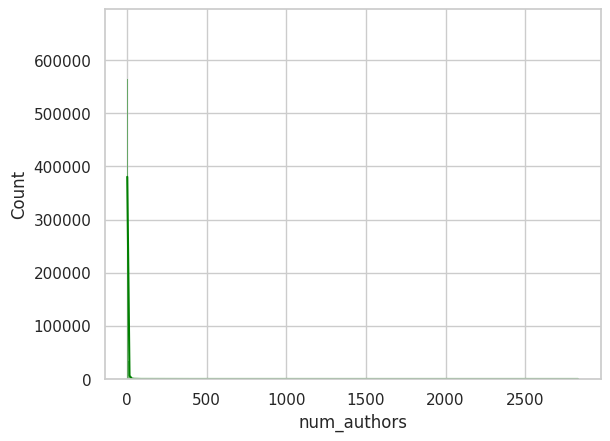

In [43]:
# strong outlier!
print(docs_df['num_authors'].max())

import seaborn as sns
sns.histplot(docs_df['num_authors'], bins=range(1, docs_df['num_authors'].max() + 2), 
             discrete=True, kde=True, color='green')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


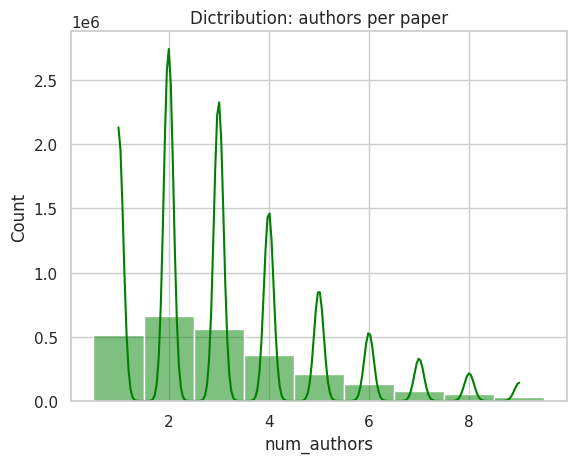

In [44]:
# to build an informative plot: exclude the maximum outlier:
import numpy as np
max_authors_95 = np.percentile(docs_df['num_authors'], 95)
filtered_df = docs_df[docs_df['num_authors'] <= max_authors_95]

sns.histplot(filtered_df['num_authors'], bins=10, 
             discrete=True, kde=True, color='green')
plt.title("Dictribution: authors per paper")
plt.show()

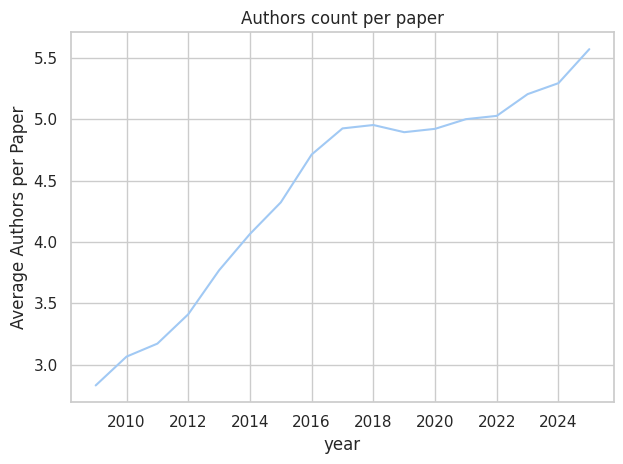

In [45]:
# group by year and calculate average number of authors per paper
docs_df['year'] = pd.to_datetime(docs_df['update_date']).dt.year
yearly_avg_authors = docs_df.groupby('year')['num_authors'].mean().rolling(window=3).mean()  # smoothed

yearly_avg_authors.plot(title='Authors count per paper')
plt.ylabel('Average Authors per Paper')
plt.grid(True)
plt.tight_layout()
plt.show()

### Update date

In [48]:
# Calculate the amount of each date in our dataset
date_counts = docs_df.loc[:, "update_date"].value_counts().sort_index()
print(date_counts.shape[0])
date_counts.head(10)

5379


update_date
2007-05-23    129958
2007-05-24        45
2007-05-25        64
2007-05-28        30
2007-05-29        58
2007-05-30        40
2007-05-31        36
2007-06-01        59
2007-06-04        51
2007-06-05        69
Name: count, dtype: int64

In [49]:
# Aggregate by months
date_counts = docs_df.resample("ME", on="update_date").size()
date_counts

update_date
2007-05-31    130231
2007-06-30      3024
2007-07-31      2653
2007-08-31      1769
2007-09-30      1862
               ...  
2025-01-31     26951
2025-02-28     31395
2025-03-31     35956
2025-04-30     36744
2025-05-31     11031
Freq: ME, Length: 217, dtype: int64

In [50]:
# Plot the distribution of dates
fig = px.bar(
    x=date_counts.index,
    y=date_counts.values,
    labels={"x": "Date", "y": "Number of Entries"},
    title="Dates distribution over time"
)

fig.update_xaxes(
    dtick="M4",
    tickformat="%b %Y",
    tickangle=45,
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Number of Entries",
    template="plotly_white"
)

fig.show()

In [51]:
date_counts.sort_values(ascending=False)

update_date
2007-05-31    130231
2009-11-30    118151
2015-06-30     79365
2009-10-31     65645
2015-05-31     51296
               ...  
2008-08-31      1900
2007-09-30      1862
2007-12-31      1857
2008-03-31      1838
2007-08-31      1769
Length: 217, dtype: int64

The amount of publications per month. However, we can see some outliers in our data:
- The first one may mean that quite a lot of publications were published/updated before 2007-05-23;
- The second one occured during the period from the beginning of October to the end of November of 2009;
- The third one occured during the period from the beginning of May to the end June of 2015.

## Abstract

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


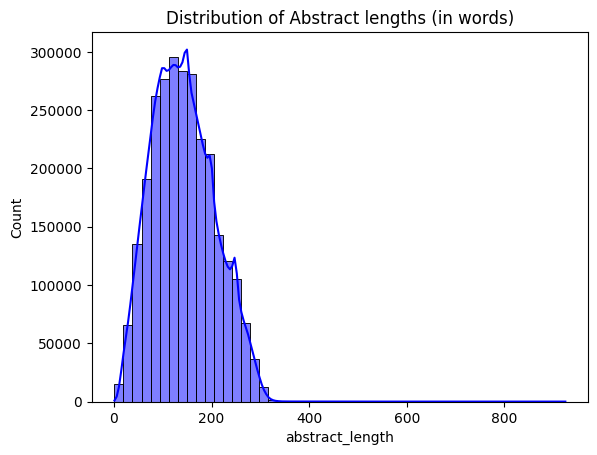

In [11]:
docs_df['abstract_length'] = docs_df['abstract'].apply(lambda x: len(x.split()))
sns.histplot(docs_df['abstract_length'], bins=50, kde=True, color='blue')
plt.title("Distribution of Abstract lengths (in words)")
plt.show()

In [12]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
def clean(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    return ' '.join([word for word in text.split() if word not in stop_words])

docs_df['clean_abstract'] = docs_df['abstract'].apply(clean)

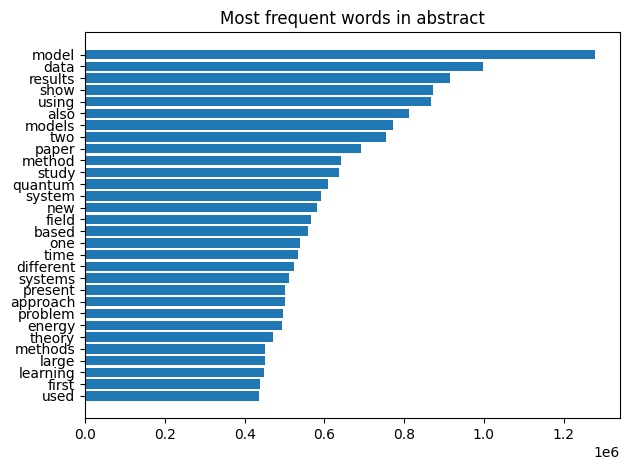

In [14]:
from collections import Counter

all_words = [word for abstract in docs_df['clean_abstract'] for word in abstract.split()]
word_counts = Counter(all_words).most_common(30)

words, counts = zip(*word_counts)
plt.barh(words, counts)
plt.title("Most frequent words in abstract")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## To see more explanations see the "Data Understanding" section in the pdf.